$$dX_t = A X_t dt + R_1 dW_t$$
$$dY_t = H X_t dt + R_2 dV_t$$

Model settings: (Conditions that the model needs to satsify)
1. Signal of dimension 'dim', and the observtations are in dimension 'dim_o'
2. $x_0|y_0 \sim N(m_0,C_0)$
3. $R_1, R_2$ is symmetric
4. $R_1$ is commutable with $A$
5. $(A+A')$ is invertible
6. For convenience purpose the target function is $\varphi(x)=x^{1}$, where $x=(x^{1},x^{2},...,x^{dim})$

In this code, I will include the $A,R_1,R_2,H,m_0,C_0$ as parameter as well, so that it's easily scalable wrt any dimension dim.
Note that dim needs to be bigger than 1, as the matrix multiplication sign '@' in python doesn't support '*' in one dimension.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt 
import progressbar
from scipy import linalg as la
from scipy.sparse import identity
from scipy.sparse import rand
from scipy.sparse import diags
from scipy.sparse import triu

def gen_model(dim):
    ## dim is dimension value
    dim_o=dim
    A1 = -rand(dim,dim,density=0.75).toarray()/1.
    A2 = triu(A1, k=1).toarray()/1.
    A = (diags(np.random.normal(-0.5,0,dim),0).toarray()/1. + A2 - A2.T)/cmm
    ## we denote R1^{1/2},R2^{1/2} as R1,R2 repectively for convenience
    ## Non-Identity covariance matrix
    R1=(identity(dim).toarray() + np.tri(dim,dim,1) - np.tri(dim,dim,-2))/amm
    R2=(identity(dim_o).toarray() + np.tri(dim_o,dim_o,1) - np.tri(dim_o,dim_o,-2))/bmm#2

    H=rand(dim_o,dim,density=0.75).toarray()/20
    m0=np.zeros(dim)+b
    C0=identity(dim).toarray()
    ## Collection of input 
    collection_input = [dim,dim_o,A,R1,R2,H,m0,C0]
    return collection_input

def gen_data(T,l,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    tau=2**(-l)
    L=la.expm(A*tau)
    ## We are going to need W to be symmetric! 
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    C=tau*H
    V=(R2@R2)*tau

    v=np.zeros((J+1,dim,1))
    z=np.zeros((J+1,dim_o,1))
    v[0]=np.random.multivariate_normal(m0,C0,(1)).T
    z[0]=np.zeros((dim_o,1))


    for j in range(J):
        ## truth
        v[j+1] = L@v[j] + np.random.multivariate_normal(np.zeros(dim),W,(1)).T
        ## observation
        z[j+1] = z[j] + C@v[j+1] + np.random.multivariate_normal(np.zeros(dim_o),V,(1)).T
        
    return([z,v])

def cut(T,lmax,l,v):
    ind = np.arange(T*2**l+1)
    rtau = 2**(lmax-l)
    w = v[ind*rtau]
    return(w)

def KBF(T,l,lmax,z,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    tau=2**(-l)
    L=la.expm(A*tau)
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    ## C: dim_o*dim matrix
    C=tau*H
    V=(R2@R2)*tau
    
    z=cut(T,lmax,l,z)
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    m[0]=6*np.ones((dim,1))
    c[0]=C0
    
    for j in range(J):
        ## prediction mean-dim*1 vector
        mhat=L@m[j]
        ## prediction covariance-dim*dim matrix
        chat=L@c[j]@(L.T)+W
        ## innovation-dim_o*1 vector
        d=(z[j+1]-z[j])-C@mhat
        ## Kalman gain-dim*dim_o vector
        K=(chat@(C.T))@la.inv(C@chat@(C.T)+V)
        ## update mean-dim*1 vector
        m[j+1]=mhat+K@d
        ## update covariance-dim*dim matrix
        c[j+1]=(I-K@C)@chat
        
    return([m,c])

def EnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    inv=la.inv(R2)@la.inv(R2)
    for j in range(J):
        dw = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
        dv = np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,N).T
        ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
        ## x-m[j]:dim*N c[j]:dim*dim
        
        step1=(((x-m[j]).T)@(H.T))
        step2=step1@(inv)
        step3=step2@( (z[j+1]-z[j]) - (H@x*dt + R2@dv) )
        step4=(x-m[j])@step3 /(N-1)
        
        x = x + A@x*dt + R1@dw + step4
        m[j+1] = (np.mean(x, axis=1)).reshape(dim,1)

    return([m,c])

def EnKBF1(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    with progressbar.ProgressBar(max_value=J) as bar:
        for j in range(J):
            dw = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
            dv = np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,N).T
            ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
            ## x-m[j]:dim*N c[j]:dim*dim
        
            step1=(((x-m[j]).T)@(H.T))
            step2=step1@(la.inv(R2)@la.inv(R2))
            step3=step2@( (z[j+1]-z[j]) - (H@x*dt + R2@dv) )
            step4=(x-m[j])@step3 /(N-1)
        
            x = x + A@x*dt + R1@dw + step4
            m[j+1] = (np.mean(x, axis=1)).reshape(dim,1)
            bar.update(J)

    return([m,c])



def CEnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**(l-1))
    I=identity(dim).toarray()
    I1=identity(dim_o).toarray()
    dt=2**(-l)
    dt1=2**(-l+1)
    m=np.zeros((J*2+1,dim,1))
    m1=np.zeros((J+1,dim,1))
    c=np.zeros((J*2+1,dim,dim))
    c1=np.zeros((J+1,dim,dim))
    z1=cut(T,lmax,l-1,z)
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    x1 = x
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    m1[0]=m[0]
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    c1[0]=c[0]
    
    dw=np.zeros((2,dim,N))
    dv=np.zeros((2,dim_o,N))
    inv=(la.inv(R2)@la.inv(R2))
    for j in range(J):
        for s in range(2):
            dw[s] = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
            dv[s] = np.random.multivariate_normal(np.zeros(dim_o),dt*I1,N).T
                ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
                ## x-m[j]:dim*N c[j]:dim*dim

            step1=(((x-m[2*j+s]).T)@(H.T))
            step2=step1@inv
            step3=step2@( (z[2*j+s+1]-z[2*j+s]) - (H@x*dt + R2@dv[s]) )
            step4=(x-m[2*j+s])@step3 /(N-1)

            x = x + A@x*dt + R1@dw[s] + step4
            m[2*j+s+1] = (np.mean(x, axis=1)).reshape(dim,1)
        
        step1=(((x1-m1[j]).T)@(H.T))
        step2=step1@inv
        step3=step2@( (z1[j+1]-z1[j]) - (H@x1*dt1 + R2@(dv[0]+dv[1])) )
        step4=(x1-m1[j])@step3 /(N-1)
            
        x1 = x1 + A@x1*dt1 + R1@(dw[0]+dw[1]) + step4
        m1[j+1] = (np.mean(x1, axis=1)).reshape(dim,1)
        
    return([m,m1])


def DEnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    for j in range(J):
        dw = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
        dv = np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,N).T
        ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
        ## x-m[j]:dim*N c[j]:dim*dim
        
        step1=(((x-m[j]).T)@(H.T))
        step2=step1@(la.inv(R2)@la.inv(R2))
        # Only the "innovation" term here changes to the "deterministic" version
        step3=step2@( (z[j+1]-z[j]) - (H@(x+m[j])*dt)/2 )
        step4=(x-m[j])@step3 /(N-1)
        
        x = x + A@x*dt + R1@dw + step4
        m[j+1] = (np.mean(x, axis=1)).reshape(dim,1)

    return([m,c])

def DCEnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**(l-1))
    I=identity(dim).toarray()
    I1=identity(dim_o).toarray()
    dt=2**(-l)
    dt1=2**(-l+1)
    
    m=np.zeros((J*2+1,dim,1))
    m1=np.zeros((J+1,dim,1))
    c=np.zeros((J*2+1,dim,dim))
    c1=np.zeros((J+1,dim,dim))
    z1=cut(T,lmax,l-1,z)
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    x1 = x
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    m1[0]=m[0]
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    c1[0]=c[0]
    
    dw=np.zeros((2,dim,N))
    dv=np.zeros((2,dim_o,N))
    inv=(la.inv(R2)@la.inv(R2))
    for j in range(J):
        for s in range(2):
            dw[s] = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
            dv[s] = np.random.multivariate_normal(np.zeros(dim_o),dt*I1,N).T
            ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
            ## x-m[j]:dim*N c[j]:dim*dim

            step1=(((x-m[2*j+s]).T)@(H.T))
            step2=step1@inv
            step3=step2@( (z[2*j+s+1]-z[2*j+s]) - (H@(x+m[2*j+s])*dt)/2 )
            step4=(x-m[2*j+s])@step3 /(N-1)

            x = x + A@x*dt + R1@dw[s] + step4
            m[2*j+s+1] = (np.mean(x, axis=1)).reshape(dim,1)
        
        step1=(((x1-m1[j]).T)@(H.T))
        step2=step1@inv
        
        step3=step2@( (z1[j+1]-z1[j]) - (H@(x1+m1[j])*dt1)/2 )
        step4=(x1-m1[j])@step3 /(N-1)
        
        x1 = x1 + A@x1*dt1 + R1@(dw[0]+dw[1]) + step4
        m1[j+1] = (np.mean(x1, axis=1)).reshape(dim,1)
        
    return([m,m1])
  
def coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return np.asarray((b_0, b_1)) 


### Paramter Tuning: 
#####  (i) For EnKBF, in order to target a certain MSE value, we need to banlance this two terms above as 
$$
\mathbb{E}[\|\eta_{t}^{N,l}(e)-\eta_{t}(e)\|^2]  = \mathbb{E}[\|\eta_{t}^{N,l}(e) - \eta_{t}^{l}(e)\|^2] + \|\eta_{t}^{l}(e) - \eta_{t}(e)\|^2
$$

From Proposition 2.1 of our paper, we know that EnKBF estimator $\eta_{t}^{N,l}(e)$ satisfies

1. $ \mathbb{E}[\|\eta_{t}^{N,l}(e) - \eta_{t}^{l}(e)\|^2] \approx C_{1}(\frac{1}{N})$

2. $  \|\eta_{t}^{l}(e) - \eta_{t}(e)\| \approx C_{2}(\Delta_{l})$

We simulate to obtain this two constants $C_{1}$, $C_{2}$. Values of $\eta_{t}^{l}(\varphi)$ can be approximated with EnKBF with huge $N$.

##### To target a MSE of $\mathcal{O}(\epsilon^2)$, we choose $N = \epsilon^{-2}C_{1}$, $\Delta_{l} = \frac{\epsilon}{C_{2}}$, the cost required for EnKBF is represented by the number of discretization steps involved
$$
Cost_{enkbf} = N \Delta_{l}^{-1} t = tC_{1}C_{2}\epsilon^{-3} = \mathcal{O}(\epsilon^{-3})
$$

##### (ii) For MLEnKBF,  

Remark: For the models used in the simulation, EnKBF with $l \leq 2$ sometimes output exploding values, for $l >2$ this issue doesn't exist, which suggest that we should consider using for MLEnKBF for $L>3$
$$
\eta_{t}^{ML}(e) = \eta_{t}^{N_{3},3}(e) + \sum_{l=4}^{L} (\eta_{t}^{l}-\eta_{t}^{l-1})^{N_{l}}(e)
$$
to simply avoid getting exploding values from our specific model settings.

The MSE of the MLEnKBF estimator is given by

$$
\mathbb{E}[\|\eta_{t}^{ML}(e)-\eta_{t}(e)\|^2]  = \mathbb{E}[\|\eta_{t}^{ML}(e) - \eta_{t}^{L}(e)\|^2] + \|\eta_{t}^{L}(e) - \eta_{t}(e)\|^2
$$

From Theorem 3.1 of our paper, we know that MLEnKBF estimator satisfies

1. $\mathbb{E}[\|\eta_{t}^{ML}(e) - \eta_{t}^{L}(e)\|^2] \approx \frac{C_{1}}{N_{3}} + C_{3} \sum_{l=4}^{L} \frac{\Delta_{l}}{N_{l}} + C_{4}\sum_{l_{1}=4}^{L}\sum_{l_{2}=4, l_{2} \neq l_{1}}^{L}\frac{\Delta_{l_{1}}}{N_{l_{1}}}\frac{\Delta_{l_{2}}}{N_{l_{2}}} \approx \frac{C_{1}}{N_{3}} + C_{3} \sum_{l=4}^{L} \frac{\Delta_{l}}{N_{l}}$

We remark here that the third term above is in practice much smaller than the first & second term thus can be ignored

In order to tune values of $C_3$, recall that Proposition D.4 gives

2. $\mathbb{E}[\|(\eta_{t}^{l}-\eta_{t}^{l-1})^{N_l}(e) - (\eta_{t}^{l}-\eta_{t}^{l-1})(e)\|^2] \approx C_{3} \frac{\Delta_{l}}{N_{l}}$

We can thus simulate CEnKBF to obtain $C_{3}$ for our specific model, too.

##### To target a MSE of $\mathcal{O}(\epsilon^{2})$ for MLEnKBF , we choose $\Delta_{L} = \frac{\epsilon}{C_{2}}$, $N_{3}=C_{1}\epsilon^{-2}$, $N_{l} = \epsilon^{-2}\Delta_{l}C_{3}(L-3) $ for $l \in \{4,5,...,L\}$, the cost required for MLEnKBF is represented by the number of discretization steps involved
$$
Cost_{mlenkbf} = t\sum_{l=3}^{L}N_{l}\Delta_{l}^{-1} = tC_{1}\Delta_{3}^{-1}\epsilon^{-2} + \sum_{l=4}^{L}C_{3}(L-3)\epsilon^{-2} = \mathcal{O}(\epsilon^{-2}\log(\epsilon)^2)
$$




##### For Determinisitc D-EnKBF/MLD-EnKBF, similar tuning is applied.

In [3]:
### In order to construct (D)MLEnKBF, we will need values of c1,c2,c3 to be fitted out first

In [4]:
#def Numcal(C,L):
#    Num=np.zeros(L+1)
#    epsilon = np.sqrt(2)*c2 * 2**(-L)
#    Num[3] = int(2*c1 * epsilon**(-2))
#    for li in range(4,L+1):
#        Num[li]=np.ceil(int(2*epsilon**(-2)*c3*(L-3)*2**(-li)))
#    return(Num*C)

def MLEnKBF(C,T,L,lmax,l0,z,collection_input):
    Num=Numcal(C,L,l0)
    telescopic_summand=np.zeros(L-l0+1)
    [m,c]=EnKBF(T,l0,lmax,z,int(Num[0]),collection_input)
    telescopic_summand[0]=m[-1,0]
    for l in range(l0+1,L+1):
        [m1,m2]=CEnKBF(T,l,lmax,z,int(Num[l]),collection_input)
        telescopic_summand[l-l0]=m1[-1,0]-m2[-1,0]
    est=np.sum(telescopic_summand)
    return(est)

In [5]:
def cost_enkbf(T,L):
    epsilon = c2 * 2**(-L)
    cost=int(T*c1*c2*epsilon**(-3))
    return(cost)

def cost_mlenkbf(C,T,L,l0):
    num=Numcal(C,L,l0,w1,w2)
    kk=num[0]*2**(l0)
    for l in range(l0,L):
        kk=kk+num[l-l0]*(2**(l+1))*3/2.
    return(T*kk)

In [6]:
def Numcal_D(C,L):
    Num=np.zeros(L+1)
    epsilon = c2 * 2**(-L)
    Num[3] = int(c1 * epsilon**(-2))
    for li in range(4,L+1):
        Num[li]=int(epsilon**(-2)*c3*(L-3)*2**(-li))
    return(Num*C)


def MLDEnKBF(C,T,L,lmax,l0,z,collection_input):
    Num=Numcal(C,L,l0)
    telescopic_summand=np.zeros(L-l0+1)
    [m,c]=DEnKBF(T,l0,lmax,z,int(Num[0]),collection_input)
    telescopic_summand[0]=m[-1,0]
    for l in range(l0+1,L+1):
        [m1,m2]=DCEnKBF(T,l,lmax,z,int(Num[l]),collection_input)
        telescopic_summand[l-l0]=m1[-1,0]-m2[-1,0]
    est=np.sum(telescopic_summand)
    return(est)

In [7]:
def cost_denkbf(T,L):
    epsilon = c2 * 2**(-L)
    cost=int(T*c1*c2*epsilon**(-3))
    return(cost)


def cost_mldenkbf(C,T,L,l0):
    num=Numcal(C,L,l0)
    kk=num[0]*2**(l0)
    for l in range(l0,L):
        kk=kk+num[l]*(2**(l+1))*3/2.
    return(T*kk)

##### 1. $\mathbb{E}[\|(\eta_{t}^{l,N}(\varphi)-\eta_{t}^{l}(\varphi))\|^2] \approx C_{1}(\frac{1}{N})$
##### 2. $\|\eta_{t}^{l}(e) - \eta_{t}(e)\| \approx C_{2}(\Delta_{l})$
##### 3. $\mathbb{E}[\|(\eta_{t}^{l}-\eta_{t}^{l-1})^{N_l}(e) - (\eta_{t}^{l}-\eta_{t}^{l-1})(e)\|^2] \approx C_{3} \frac{\Delta_{l}}{N_{l}}$
##### 4. Simulation to get MSE of MLEnKBF & EnKBF for $l \in \{4,5,6,7,8,9\}$

In [8]:
def dsimulate_mse(seed_val):
    np.random.seed(seed_val)
    lmax = 12
    dim = 10
    T=10
    collection_input = gen_model(dim)
    z = gen_data(T,lmax,collection_input)[0]
    N=1000
    
    tv_rep = np.zeros((Rep,dim))
    for rep in range(Rep):
        tv_rep[rep] = DEnKBF(T,lmax,lmax,z,N,collection_input)[0][-1,:][:,0]
    tv_approx = np.mean(tv_rep,axis=0)
    mse_level=np.zeros(10)
    #delt_level=np.zeros(10)
    C=2.1
    Rep=100
    for l in range(4,10):
        est_ml=np.zeros(Rep)
        #est_en=np.zeros(Rep)
        for rep in range(Rep):
            with np.errstate(divide='ignore'):
                #mean_en = EnKBF(T,l,lmax,z,N,collection_input)[0][-1,:]
                mean_ml = MLDEnKBF(C,T,L,lmax,z,collection_input)
                est_ml[rep] = np.sum((mean_ml - tv_approx)**2)
                est_en[rep] = np.sum((mean_en - tv_approx)**2)
        mse_ml[l] = np.mean(est_ml)
        mse_en[l] = np.mean(est_en)
    
    return mse_ml[4:10],mse_en[4:10]

##### 1. $\mathbb{E}[\|(\eta_{t}^{l,N}(\varphi)-\eta_{t}^{l}(\varphi))\|^2] \approx C_{1}(\frac{1}{N})$
##### 2. $\|\eta_{t}^{l}(e) - \eta_{t}(e)\| \approx C_{2}(\Delta_{l})$
##### 3. $\mathbb{E}[\|(\eta_{t}^{l}-\eta_{t}^{l-1})^{N_l}(e) - (\eta_{t}^{l}-\eta_{t}^{l-1})(e)\|^2] \approx C_{3} \frac{\Delta_{l}}{N_{l}}$
##### 4. Simulation to get MSE of D-MLEnKBF & D-EnKBF for $l \in \{4,5,6,7,8,9\}$

### New fit_c1 and fit_c3

In [9]:
#necessary parameters: l,collection_input, z, p, N0, Rep, T,Lmax,
def fit_c1(T,l,lz,z,collection_input,seed_val,p,N0,Rep):
    num_seq=np.zeros(p+1)
    dim=collection_input[0]
    for i in range(p+1):
        num_seq[i] = N0*2**i
    np.random.seed(seed_val)
    evar=np.zeros((p+1,dim))
    for numi in range(p+1):
        est=np.zeros((Rep,dim))
        #print("numi=",numi)
        with progressbar.ProgressBar(max_value=Rep) as bar:
            for rep in range(Rep):
                with np.errstate(divide='ignore'):
                    mean_mat =EnKBF(T,l,lz,z,int(num_seq[numi]),collection_input)[0]
                    est[rep] = mean_mat[-1,:,0]
                    #print(est[rep])
                    bar.update(rep)
                
        evar[numi] = np.var(est,axis=0)         
    bs=np.zeros((dim,2))
    x=np.log10(num_seq)
    y=np.log10(evar)
    for i in range(dim):
        bs[i]=coef(x,(y.T)[i])
    #b=coef(abscisas,ordenadas)

                
        
    
    #x = np.log10(num_seq)
    #x=np.array([i for i in range(6)])
    #y = np.log10(evar)
    #b = coef(x,y)
    plt.plot(x,y)
    plt.plot(x,(bs[:,0].reshape(dim,1)+bs[:,1].reshape(dim,1)@x.reshape(1,p+1)).T)
    #print(bs[:,0].reshape(dim,1)+bs[:,1].reshape(dim,1)@x.reshape(1,p+1))
    return 10**(bs)



In [10]:
#necessary parameters: T,lz,z,N,collection_input,seed_val,l0,L,Rep
def fit_c3( T,lz,z,N,collection_input,seed_val,l0,L,Rep):
    delta_seq = np.zeros(L-l0)
    for l in range(L-l0):
        delta_seq[l] = 2**(-(l0+1+l))
    #Rep=100
    dim=collection_input[0]
    evar=np.zeros((L-l0,dim))
    np.random.seed(seed_val)
    for l in range(L-l0):
        print("Current level ",l+l0+1,". ",L-(l+l0+1),"remaining." )
        est = np.zeros((Rep,dim))
        with progressbar.ProgressBar(max_value=Rep) as bar:
            for rep in range(Rep):
                
                with np.errstate(divide='ignore'):
                    #print(T,l+l0+1,lz,N,collection_input)
                    [m,m1]=CEnKBF(T,l+l0+1,lz,z,N,collection_input)
                    est[rep] = m[-1,:,0] -m1[-1,:,0]
                bar.update(rep)
        evar[l] = np.var(est,axis=0)
        
    bs=np.zeros((dim,2))
    x=np.log10(delta_seq)
    y=np.log10(evar)
    for i in range(dim):
        bs[i]=coef(x,(y.T)[i])
    plt.plot(x,y)
    plt.plot(x,(bs[:,0].reshape(dim,1)+bs[:,1].reshape(dim,1)@x.reshape(1,L-l0)).T)

    return [bs,N*10**(bs)]

Experiments global variable and input variables

### Parameter search: T=80, dim=100.

In [11]:
T=80
dim=100
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=0.005
cmm=50.
b=6
lz=11
l=3
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_col)
collection_input=gen_model(dim)
np.random.seed(seed_val_obs)
[z,v] = gen_data(T,lz,collection_input)
ems=np.zeros((B,J+1,dim,1))
#[m,c] = KBF(T,l,lmax,z,collection_input)
## The with numpy.errstate argument is used to avoid any stupid warning

#EnKBF(T,l,lz,z,N,collection_input)

In [12]:
zshape=z.shape
vshape=v.shape
print(z.shape)
print(v.shape)
zreshaped=z.reshape(z.shape[0],-1)
vreshaped=v.reshape(v.shape[0],-1)
np.savetxt('obsT80d100.txt', zreshaped, fmt='%f')
np.savetxt('realiT80d100.txt', vreshaped, fmt='%f')

(163841, 100, 1)
(163841, 100, 1)


In [13]:
T=80
dim=100
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=0.005
cmm=50.
b=6
lz=11
l=3
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_col)
collection_input=gen_model(dim)
zshape=(163841, 100, 1)
vshape=(163841, 100, 1)
zload=np.loadtxt('obsT80d100.txt', dtype=float)
vload=np.loadtxt('realiT80d100.txt', dtype=float)
print(np.shape(zload))
z=zload.reshape(zshape)
v=vload.reshape(vshape)

(163841, 100)


In [5]:
np.random.seed(1)
l=9
N=400
#EnKBF(T,l,lz,z,N,collection_input)[0][:10]

array([[ -8.8125576 ],
       [ -7.24313729],
       [  0.5370405 ],
       [ -8.65285622],
       [ -3.19018438],
       [ -6.80307598],
       [-12.06196058],
       [-17.06805217],
       [-15.39961489],
       [ -9.32580075],
       [ -6.80956087],
       [ -5.6885664 ],
       [ -6.05720437],
       [ -5.46073561],
       [ -4.9518908 ],
       [  1.61831766],
       [ -7.53141993],
       [  3.3812314 ],
       [  1.72009248],
       [  3.48382419],
       [ -2.34386564],
       [  2.86125444],
       [ -5.48555251],
       [  7.09950715],
       [ -1.51489902],
       [ -1.43641488],
       [  5.41315886],
       [  1.88971352],
       [ -2.59643126],
       [  3.28349053],
       [ -0.71564652],
       [  2.30941059],
       [ -7.46960352],
       [  1.91035688],
       [  4.31813114],
       [  3.32894295],
       [  2.55392626],
       [  3.248212  ],
       [  4.0999031 ],
       [ 11.44424687],
       [  1.44532604],
       [ -4.13885376],
       [ -1.86905685],
       [  8

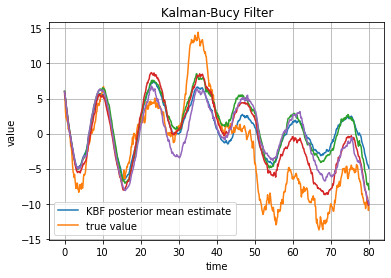

In [18]:
ind=1
ems=np.zeros((B,J+1,dim,1))
m=np.zeros((J+1,dim,1))
N=200
l=3

with np.errstate(divide='ignore'):
    m=KBF(T,l,lz,z,collection_input)[0]
    for i in range(B):
        ems[i] = DEnKBF(T,l,lz,z,N,collection_input)[0]
        
        #[m2,c2] = DEnKBF(T,l,lmax,z,N,collection_input)
v1=cut(T,lz,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
#print(m1[:,2].T[0])
plt.plot(x1,m[:,ind],label="KBF posterior mean estimate")
plt.plot(x1,v1[:,ind],label="true value")
for i in range(B):
    plt.plot(x1,ems[i,:,ind,0])
#plt.plot(x1,m2[:,0],label="DEnKBF posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
EnKBF(T,l,lz,z,N,collection_input)[0][-1]

Check the data 

In [36]:
N0=50
l=3
p=6
seed_val=1
Rep=100

100% (100 of 100) |######################| Elapsed Time: 0:03:13 Time:  0:03:13
100% (100 of 100) |######################| Elapsed Time: 0:03:42 Time:  0:03:42
100% (100 of 100) |######################| Elapsed Time: 0:04:48 Time:  0:04:48
100% (100 of 100) |######################| Elapsed Time: 0:07:17 Time:  0:07:17
100% (100 of 100) |######################| Elapsed Time: 0:12:48 Time:  0:12:48
100% (100 of 100) |######################| Elapsed Time: 0:30:16 Time:  0:30:16
100% (100 of 100) |######################| Elapsed Time: 1:16:04 Time:  1:16:04


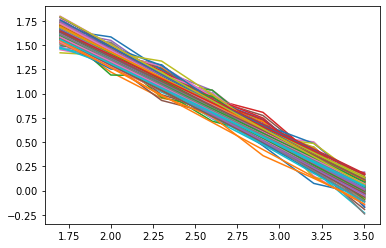

In [37]:
c1s=fit_c1(T,l,lz,z,collection_input,seed_val,p,N0,Rep)

In [38]:
c1s

array([[1.90543100e+03, 1.17465403e-01],
       [1.74647510e+03, 1.21570984e-01],
       [2.12722483e+03, 1.13158994e-01],
       [3.23115996e+03, 9.74865570e-02],
       [1.58386440e+03, 1.26621998e-01],
       [1.41803473e+03, 1.29615077e-01],
       [1.86329531e+03, 1.24070446e-01],
       [1.63185032e+03, 1.31958734e-01],
       [1.53734571e+03, 1.32702126e-01],
       [1.28968275e+03, 1.26214663e-01],
       [1.69148193e+03, 1.16481031e-01],
       [8.34107191e+02, 1.50684677e-01],
       [1.05987074e+03, 1.44520222e-01],
       [1.88039379e+03, 1.20027159e-01],
       [1.75354173e+03, 1.24401126e-01],
       [1.40970681e+03, 1.40826054e-01],
       [1.81891534e+03, 1.16746449e-01],
       [1.18977035e+03, 1.34767502e-01],
       [1.45801058e+03, 1.27660816e-01],
       [9.48359602e+02, 1.53115381e-01],
       [2.66710539e+03, 9.76260514e-02],
       [1.64643096e+03, 1.17754175e-01],
       [1.38190580e+03, 1.24631094e-01],
       [1.56669991e+03, 1.27520311e-01],
       [1.538157

In [43]:
N=50
l0=3
L=8
Rep=100

Current level  4 .  4 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:04:28 Time:  0:04:28


Current level  5 .  3 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:08:52 Time:  0:08:52


Current level  6 .  2 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:17:31 Time:  0:17:31


Current level  7 .  1 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:35:35 Time:  0:35:35


Current level  8 .  0 remaining.


100% (100 of 100) |######################| Elapsed Time: 1:46:20 Time:  1:46:20


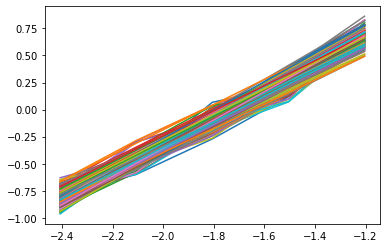

In [44]:
c3s=fit_c3(T,lz,z,N,collection_input,seed_val,l0,L,Rep)

In [45]:
c3s

[array([[2.00933699, 1.20899851],
        [1.94927259, 1.11545379],
        [2.0415577 , 1.18181634],
        [2.24903639, 1.28144581],
        [2.08138976, 1.19880078],
        [2.19104017, 1.25663565],
        [2.07314755, 1.19113125],
        [2.4573806 , 1.36136003],
        [2.13560373, 1.21397474],
        [1.97880719, 1.1865857 ],
        [2.12351962, 1.26734233],
        [2.0848448 , 1.2348793 ],
        [1.98035562, 1.14479769],
        [2.00873052, 1.15462869],
        [1.97711104, 1.11180756],
        [2.22785298, 1.24505468],
        [2.06654355, 1.16905156],
        [2.10811676, 1.23620766],
        [1.8346174 , 1.10224789],
        [2.16864445, 1.22691154],
        [2.00697945, 1.15708091],
        [2.01972376, 1.20401328],
        [2.19924839, 1.29957288],
        [2.29013879, 1.29313383],
        [1.98836486, 1.17584257],
        [2.0767674 , 1.19546549],
        [2.0052978 , 1.18985094],
        [2.16692964, 1.26758475],
        [2.21153147, 1.26524123],
        [2.157

In [14]:
c1=1289.68275
c2=4.63
c3=4761.86626672

In [19]:
def Numcal(C,L,l0,w1,w2):
    Num=np.zeros(L-l0+1)
    epsilon = np.sqrt(2)*c2 * 2**(-L)/np.sqrt(w1)
    Num[0] = np.ceil(4*c1 * epsilon**(-2)/w2)
    for li in range(1,L-l0+1):
        Num[li]=np.maximum(np.ceil(2*epsilon**(-2)*c3*(L-l0)*2**(-li))/w2,2)
        
    return(np.ceil(Num*C))


In [20]:
L=8
l0=3
w1=1/100.
w2=99/100.
for l in range(l0,L):
    print(Numcal(1,l,l0,w1,w2))
    maxi=np.max(Numcal(1,l,l0,w1,w2))
    C=np.maximum(1,np.int(maxi/800))
    print(1/C)
    print(Numcal(1/C,l,l0,w1,w2))
    print(C)

[78.]
1.0
[78.]
1
[312. 288.]
1.0
[312. 288.]
1
[1245. 2298. 1150.]
0.5
[ 623. 1149.  575.]
2
[ 4979. 13786.  6893.  3447.]
0.058823529411764705
[293. 811. 406. 203.]
17
[19913. 73525. 36763. 18382.  9191.]
0.01098901098901099
[219. 808. 404. 202. 101.]
91


In [21]:
def simulate_mse(seed_val,c1,c2,c3,L,l0,lz,z,collection_input,T,w1,w2):
    
    epsilon = np.sqrt(2)*c2*2**(-L-2)/np.sqrt(w1)
    print("epsilon=",epsilon)
    N=np.int(2*c1/(epsilon**2*w2))
    print("N=",N)
    lmax=lz
    N=np.maximum(N,800)
    Rep=np.int(N/800)
    if Rep>1:
        N=800
    print("Rep=",Rep)
    Rep=0
    dim=collection_input[0]
    tv_rep = np.zeros((Rep,dim))
    with progressbar.ProgressBar(max_value=Rep) as bar:
        for rep in range(Rep):
            tv_rep[rep] = EnKBF(T,L+2,lmax,z,N,collection_input)[0][-1,:,0]
            bar.update(rep)   
    tv_approx = np.mean(tv_rep,axis=0)
    mse_ml=np.zeros((L-l0+1,dim))
    levels=np.array(range(l0,L+1))
    mean_ml=np.zeros((L-l0+1,dim))
    #delt_level=np.zeros(10)
    #C=3.
    Rep=100
    costs=np.zeros(L-l0+1)
    for l in range(l0,L+1):
        #next we determine the value C so the maximum number of particles of all levels is 800
        maxi=np.max(Numcal(1,l,l0,w1,w2))
        C=1/np.maximum(1,np.int(maxi/800))
        est_ml=np.zeros((Rep,dim))
        #est_en=np.zeros(Rep)
        print("Current level is",l,".",L-l, "remaining.")
        with progressbar.ProgressBar(max_value=Rep) as bar:
            ML_real=np.zeros((Rep,dim))
            print(Numcal(C,l,l0,w1,w2))
            for rep in range(Rep):
                with np.errstate(divide='ignore'):
                    #mean_en = DEnKBF(T,l,lmax,z,N,collection_input)[0][-1,:]
                    #print(T,l)
                    Cinv=np.int(1/C)
                    Creps=np.zeros((Cinv,dim))
                    for crep in range(Cinv):
                        Creps[crep]=MLEnKBF(C,T,l,lmax,l0,z,collection_input,w1,w2)
                    
                    
                    ML_real[rep] = np.mean(Creps,axis=0)
                    
                    est_ml[rep] = (ML_real[rep] - tv_approx)**2
                    #est_en[rep] = np.sum((mean_en - tv_approx)**2)
                    bar.update(rep)
            mean_ml[l-l0]=np.mean(ML_real,axis=0)       
            mse_ml[l-l0]=np.mean(est_ml,axis=0)
            costs[l-l0]=Cinv*cost_mlenkbf(C,T,l,l0)
            
        #print(mse_ml[l-l0])
    
    return [mse_ml,levels,costs,mean_ml,tv_approx]

In [29]:
def MLEnKBF(C,T,L,lmax,l0,z,collection_input,w1,w2):
    Num=Numcal(C,L,l0,w1,w2)
    telescopic_summand=np.zeros((L-l0+1,dim))
    [m,c]=EnKBF(T,l0,lmax,z,int(Num[0]),collection_input)
    telescopic_summand[0]=m[-1,:,0]
    for l in range(l0+1,L+1):
        [m1,m2]=CEnKBF(T,l,lmax,z,int(Num[l-l0]),collection_input)
        telescopic_summand[l-l0]=m1[-1,:,0]-m2[-1,:,0]
    est=np.sum(telescopic_summand,axis=0)
    return(est)

In [31]:
L=6
l0=3
MLEnKBF(C,T,L,lz,l0,z,collection_input,w1,w2)

In [ ]:
L=7
l0=3
seed_val=1

[MSE,levels,cost,mean_ml,tv_approx]=simulate_mse(seed_val,c1,c2,c3,L,l0,lz,z,collection_input,T,w1,w2)

- |#                                                  | 0 Elapsed Time: 0:00:00


epsilon= 0.12788689050366073
N= 159303
Rep= 199
Current level is 3 . 4 remaining.
[78.]


100% (100 of 100) |######################| Elapsed Time: 0:03:14 Time:  0:03:14


Current level is 4 . 3 remaining.
[312. 288.]


100% (100 of 100) |######################| Elapsed Time: 0:21:07 Time:  0:21:07


Current level is 5 . 2 remaining.
[ 623. 1149.  575.]


 43% (43 of 100) |#########              | Elapsed Time: 1:12:17 ETA:   1:24:16

In [196]:
##############################################################################################

### Parameter search, T=80, dim=10

In [11]:
T=80
dim=10
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=2.
cmm=50.
b=6
lz=11
l=4
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_obs)
collection_input=gen_model(dim)
[z,v] = gen_data(T,lz,collection_input)
#[m,c] = KBF(T,l,lmax,z,collection_input)
ems=np.zeros((B,J+1,dim,1))
np.random.seed(seed_val_col)
## The with numpy.errstate argument is used to avoid any stupid warning
#EnKBF(T,l,lz,z,N,collection_input)

array([[-9.77010152],
       [-6.65883072],
       [ 9.83229661],
       [ 4.30598169],
       [14.38104924],
       [-5.98937606],
       [-7.71949616],
       [-0.45596432],
       [-2.77305867],
       [-3.45067053]])

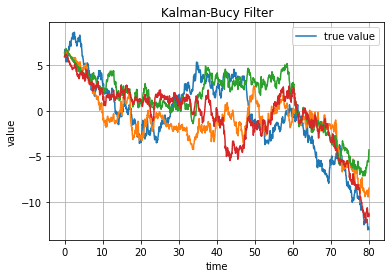

In [12]:
with np.errstate(divide='ignore'):
    
    for i in range(B):
        ems[i] = EnKBF(T,l,lz,z,N,collection_input)[0]
        
        #[m2,c2] = DEnKBF(T,l,lmax,z,N,collection_input)
v1=cut(T,lz,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
#print(m1[:,2].T[0])
#plt.plot(x1,m[:,0],label="KBF posterior mean estimate")
plt.plot(x1,v1[:,0],label="true value")
for i in range(B):
    plt.plot(x1,ems[i,:,0,0])
#plt.plot(x1,m2[:,0],label="DEnKBF posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
EnKBF(T,l,lz,z,N,collection_input)[0][-1]

In [13]:
l=4
seed_val=1
p=6
N0=50
Rep=100

100% (100 of 100) |######################| Elapsed Time: 0:01:04 Time:  0:01:04
100% (100 of 100) |######################| Elapsed Time: 0:01:39 Time:  0:01:39
100% (100 of 100) |######################| Elapsed Time: 0:01:54 Time:  0:01:54
100% (100 of 100) |######################| Elapsed Time: 0:02:36 Time:  0:02:36
100% (100 of 100) |######################| Elapsed Time: 0:04:54 Time:  0:04:54
100% (100 of 100) |######################| Elapsed Time: 0:19:25 Time:  0:19:25
100% (100 of 100) |######################| Elapsed Time: 0:45:42 Time:  0:45:42


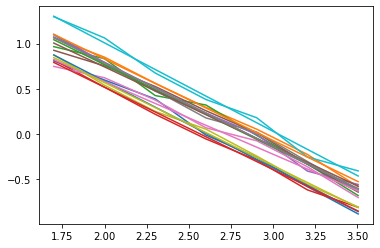

In [14]:
c1s=fit_c1(T,l,lz,z,collection_input,seed_val,p,N0,Rep)

In [15]:
c1s

array([[3.19317340e+02, 1.09713083e-01],
       [4.33329422e+02, 1.25001994e-01],
       [3.97748793e+02, 1.21313998e-01],
       [2.19054545e+02, 1.22523081e-01],
       [4.56642875e+02, 1.16577088e-01],
       [3.14536380e+02, 1.32452681e-01],
       [1.54381622e+02, 1.56840141e-01],
       [4.33259784e+02, 1.18759423e-01],
       [2.54926584e+02, 1.20446618e-01],
       [9.27407785e+02, 1.04818441e-01]])

In [16]:
N=100
l0=4
L=9

Current level  5 .  4 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:01:58 Time:  0:01:58


Current level  6 .  3 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:04:00 Time:  0:04:00


Current level  7 .  2 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:08:03 Time:  0:08:03


Current level  8 .  1 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:16:10 Time:  0:16:10


Current level  9 .  0 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:33:03 Time:  0:33:03


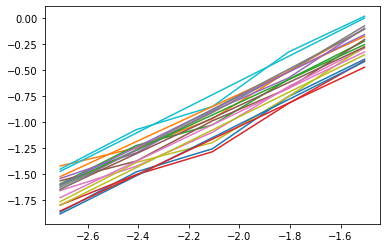

In [17]:
c3s=fit_c3(T,lz,z,N,collection_input,seed_val,l0,L,Rep)

In [18]:
c3s

[array([[1.41136305, 1.21582561],
        [1.50651377, 1.11893772],
        [1.43286253, 1.12235959],
        [1.25267623, 1.14709438],
        [1.64278497, 1.19799459],
        [1.42684535, 1.13391023],
        [1.4251854 , 1.16347567],
        [1.81928385, 1.28067922],
        [1.45069111, 1.19939376],
        [1.83915482, 1.22294833]]),
 array([[2578.47575123, 1643.71157933],
        [3210.06458732, 1315.03623227],
        [2709.33387099, 1325.4385411 ],
        [1789.27142357, 1403.11860627],
        [4393.24044322, 1577.59160048],
        [2672.05470625, 1361.16330345],
        [2661.86115775, 1457.05408285],
        [6596.04867631, 1908.44311259],
        [2822.87148271, 1582.6823472 ],
        [6904.85908496, 1670.89181628]])]

In [ ]:
def simulate_mse(seed_val):
    
    lmax = Lmax
    #dim = 5
    #T=10
    np.random.seed(seed_val_col)
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,lmax,collection_input)[0]
    N=500
    Rep=100
    
    tv_rep = np.zeros((Rep,dim))
    with progressbar.ProgressBar(max_value=Rep) as bar:
        for rep in range(Rep):
            tv_rep[rep] = EnKBF(T,lmax,lmax,z,N,collection_input)[0][-1,:,0]
            bar.update(rep)
            
            
    tv_approx = np.mean(tv_rep,axis=0)
    mse_ml=np.zeros((L-l0+1,dim))
    levels=np.array(range(l0,L+1))
    mean_ml=np.zeros((L-l0+1,dim))
    delt_level=np.zeros(10)
    C=3.
    Rep=100
    costs=np.zeros(L-l0+1)
    for l in range(l0,L+1):
        est_ml=np.zeros((Rep,dim))
        #est_en=np.zeros(Rep)
        print("Current level is",l,".",L-l, "remaining.")
        with progressbar.ProgressBar(max_value=Rep) as bar:
            ML_real=np.zeros((Rep,dim))
            for rep in range(Rep):
                with np.errstate(divide='ignore'):
                    #mean_en = DEnKBF(T,l,lmax,z,N,collection_input)[0][-1,:]
                    #print(T,l)
                    ML_real[rep] = MLEnKBF(C,T,l,lmax,l0,z,collection_input)
                    seed_j=0
                    while  math.isnan(ML_real[rep,0]):
                        np.random.seed(seed_j)
                        ML_real[rep] =MLEnKBF(C,T,l,lmax,l0,z,collection_input)
                        #print(ML_real[rep])
                        seed_j+=1
                    est_ml[rep] = (ML_real[rep] - tv_approx)**2
                    #est_en[rep] = np.sum((mean_en - tv_approx)**2)
                    bar.update(rep)
            mean_ml[l-l0]=np.mean(ML_real,axis=0)       
            mse_ml[l-l0]=np.mean(est_ml,axis=0)
            costs[l-l0]=cost_mlenkbf(C,T,l,l0)
            
        #print(mse_ml[l-l0])
    
    return [mse_ml,levels,costs,mean_ml,tv_approx]

In [ ]:
def Numcal(C,L,l0):
    Num=np.zeros(L-l0+1)
    epsilon = np.sqrt(2)*c2 * 2**(-L)
    Num[0] = np.ceil(2*c1 * epsilon**(-2))
    for li in range(1,L-l0+1):
        Num[li]=np.maximum(np.ceil(2*epsilon**(-2)*c3*(L-l0)*2**(-li)),2)
        
    return(np.ceil(Num*C))

In [ ]:
def MLEnKBF(C,T,L,lmax,l0,z,collection_input):
    Num=Numcal(C,L,l0)
    telescopic_summand=np.zeros((L-l0+1,dim))
    [m,c]=EnKBF(T,l0,lmax,z,int(Num[0]),collection_input)
    telescopic_summand[0]=m[-1,:,0]
    for l in range(l0+1,L+1):
        [m1,m2]=CEnKBF(T,l,lmax,z,int(Num[l-l0]),collection_input)
        telescopic_summand[l-l0]=m1[-1,:,0]-m2[-1,:,0]
    est=np.sum(telescopic_summand,axis=0)
    return(est)

In [149]:
C=3
l0=0
N=100
lmax=6
np.random.seed(seed_val_col)
collection_input = gen_model(dim)
np.random.seed(seed_val_obs)
z = gen_data(T,Lmax,collection_input)[0]
print(MLEnKBF(C,T,6,Lmax,l0,z,collection_input))
#print(EnKBF(T,lmax,Lmax,z,N,collection_input)[0][-1])

[-2.43830611  0.86486738]


In [150]:
L=6
[MSE,levels,cost,mean_ml,tv_approx]=simulate_mse(seed_val)

100% (100 of 100) |######################| Elapsed Time: 2:17:47 Time:  2:17:47
  6% (6 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:02

Current level is 0 . 6 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 1 . 5 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 2 . 4 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:14 Time:  0:00:14


Current level is 3 . 3 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:35 Time:  0:00:35


Current level is 4 . 2 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Current level is 5 . 1 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:16:03 Time:  0:16:03


Current level is 6 . 0 remaining.


100% (100 of 100) |######################| Elapsed Time: 4:19:13 Time:  4:19:13


In [11]:
def fit_c1(seed_val,dim):
    np.random.seed(seed_val_col)
    l=3
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,Lmax,collection_input)[0]
    num_seq = np.zeros(6)
    for i in range(6):
        num_seq[i] = 50*2**i
    np.random.seed(seed_val)
    Rep=500
    evar=np.zeros(6)
    for numi in range(6):
        est=np.zeros(Rep)
        #print("numi=",numi)
        for rep in range(Rep):
            with np.errstate(divide='ignore'):
                mean_mat =EnKBF(T,l,Lmax,z,int(num_seq[numi]),collection_input)[0]
                est[rep] = np.mean(mean_mat[-1,:])
                #print(est[rep])
        evar[numi] = np.var(est)
    
    x = np.log10(num_seq)
    #x=np.array([i for i in range(6)])
    y = np.log10(evar)
    b = coef(x,y)
    plt.plot(x,y)
    plt.plot(x,b[0]+b[1]*x)
    
    return 10**(b)

In [17]:
T=80
dim=2
Lmax=11
seed_val_col=5
seed_val_obs=5
amm=10.
bmm=20.
cmm=10.

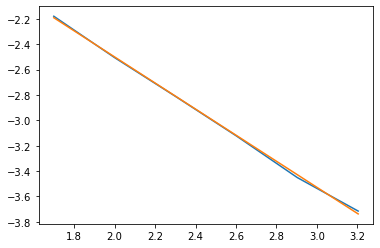

In [18]:
c1=fit_c1(42,dim)

In [143]:
#2
c1

array([0.90098574, 0.09511648])

In [13]:
def fit_c3(seed_val,dim):
    np.random.seed(seed_val_col)
    #dim = 10
    #lmax=9
    N = 100
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,Lmax,collection_input)[0]
    delta_seq = np.zeros(10)
    for l in range(10):
        delta_seq[l] = 2**(-l)
    Rep=100
    evar=np.zeros(10)
    np.random.seed(seed_val)
    for l in range(1,7):
        print("Current level ",l,". ",6-l,"remaining." )
        est = np.zeros(Rep)
        with progressbar.ProgressBar(max_value=Rep) as bar:
            for rep in range(Rep):
                with np.errstate(divide='ignore'):
                    [m,m1]=CEnKBF(T,l,Lmax,z,N,collection_input)
                    est[rep] = np.mean(m[-1,:]) - np.mean(m1[-1,:])
                    bar.update(rep)
        evar[l] = np.var(est)
        
    #x = np.log10(delta_seq[4:8])
    x=np.array(range(10))[1:7]
    y = np.log10(evar[1:7])
    b=coef(x,y)
    plt.plot(x,y)
    return N*10**(b)

In [14]:
c3=fit_c3(1,dim)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level  1 .  5 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level  2 .  4 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:14 Time:  0:00:14


Current level  3 .  3 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


Current level  4 .  2 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


Current level  5 .  1 remaining.


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:51


KeyboardInterrupt: 

In [145]:
c1=0.90098574
c2=0.633350592759386
c3=0.07894818

In [148]:
C=3
Numcal(C,6,0)

array([27603.,  7257.,  3630.,  1815.,   909.,   456.,   228.])

In [70]:
def simulate_mse(seed_val):
    
    lmax = Lmax
    #dim = 5
    #T=10
    np.random.seed(seed_val_col)
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,lmax,collection_input)[0]
    N=500
    Rep=100
    
    tv_rep = np.zeros((Rep,dim))
    with progressbar.ProgressBar(max_value=Rep) as bar:
        for rep in range(Rep):
            tv_rep[rep] = EnKBF(T,lmax,lmax,z,N,collection_input)[0][-1,:,0]
            bar.update(rep)
            
            
    tv_approx = np.mean(tv_rep,axis=0)
    mse_ml=np.zeros((L-l0+1,dim))
    levels=np.array(range(l0,L+1))
    mean_ml=np.zeros((L-l0+1,dim))
    delt_level=np.zeros(10)
    C=3.
    Rep=100
    costs=np.zeros(L-l0+1)
    for l in range(l0,L+1):
        est_ml=np.zeros((Rep,dim))
        #est_en=np.zeros(Rep)
        print("Current level is",l,".",L-l, "remaining.")
        with progressbar.ProgressBar(max_value=Rep) as bar:
            ML_real=np.zeros((Rep,dim))
            for rep in range(Rep):
                with np.errstate(divide='ignore'):
                    #mean_en = DEnKBF(T,l,lmax,z,N,collection_input)[0][-1,:]
                    #print(T,l)
                    ML_real[rep] = MLEnKBF(C,T,l,lmax,l0,z,collection_input)
                    seed_j=0
                    while  math.isnan(ML_real[rep,0]):
                        np.random.seed(seed_j)
                        ML_real[rep] =MLEnKBF(C,T,l,lmax,l0,z,collection_input)
                        #print(ML_real[rep])
                        seed_j+=1
                    est_ml[rep] = (ML_real[rep] - tv_approx)**2
                    #est_en[rep] = np.sum((mean_en - tv_approx)**2)
                    bar.update(rep)
            mean_ml[l-l0]=np.mean(ML_real,axis=0)       
            mse_ml[l-l0]=np.mean(est_ml,axis=0)
            costs[l-l0]=cost_mlenkbf(C,T,l,l0)
            
        #print(mse_ml[l-l0])
    
    return [mse_ml,levels,costs,mean_ml,tv_approx]

In [71]:
def Numcal(C,L,l0):
    Num=np.zeros(L-l0+1)
    epsilon = np.sqrt(2)*c2 * 2**(-L)
    Num[0] = np.ceil(2*c1 * epsilon**(-2))
    for li in range(1,L-l0+1):
        Num[li]=np.maximum(np.ceil(2*epsilon**(-2)*c3*(L-l0)*2**(-li)),2)
        
    return(np.ceil(Num*C))

In [72]:
def MLEnKBF(C,T,L,lmax,l0,z,collection_input):
    Num=Numcal(C,L,l0)
    telescopic_summand=np.zeros((L-l0+1,dim))
    [m,c]=EnKBF(T,l0,lmax,z,int(Num[0]),collection_input)
    telescopic_summand[0]=m[-1,:,0]
    for l in range(l0+1,L+1):
        [m1,m2]=CEnKBF(T,l,lmax,z,int(Num[l-l0]),collection_input)
        telescopic_summand[l-l0]=m1[-1,:,0]-m2[-1,:,0]
    est=np.sum(telescopic_summand,axis=0)
    return(est)

In [149]:
C=3
l0=0
N=100
lmax=6
np.random.seed(seed_val_col)
collection_input = gen_model(dim)
np.random.seed(seed_val_obs)
z = gen_data(T,Lmax,collection_input)[0]
print(MLEnKBF(C,T,6,Lmax,l0,z,collection_input))
#print(EnKBF(T,lmax,Lmax,z,N,collection_input)[0][-1])

[-2.43830611  0.86486738]


In [150]:
L=6
[MSE,levels,cost,mean_ml,tv_approx]=simulate_mse(seed_val)

100% (100 of 100) |######################| Elapsed Time: 2:17:47 Time:  2:17:47
  6% (6 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:02

Current level is 0 . 6 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 1 . 5 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 2 . 4 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:14 Time:  0:00:14


Current level is 3 . 3 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:35 Time:  0:00:35


Current level is 4 . 2 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Current level is 5 . 1 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:16:03 Time:  0:16:03


Current level is 6 . 0 remaining.


100% (100 of 100) |######################| Elapsed Time: 4:19:13 Time:  4:19:13


T=80, dim=2 down

In [151]:
tv_approx

array([-2.42298987,  0.85720075])

Great, the bias is well computed

In [152]:
MSE=np.sum(MSE,axis=1)
MSE

array([8.94486038e-01, 3.54717817e-01, 1.18287233e-01, 2.14869872e-02,
       5.77839112e-03, 1.48224773e-03, 4.52070244e-04])

In [154]:
[MSE,cost,mean_ml,tv_approx]=[np.array([8.94486038e-01, 3.54717817e-01, 1.18287233e-01, 2.14869872e-02,
        5.77839112e-03, 1.48224773e-03, 4.52070244e-04]),
 np.array([7.200000e+02, 8.640000e+03, 4.032000e+04, 1.944000e+05,
        9.950400e+05, 5.112000e+06, 2.627856e+07]),
 np.array([[-2.98088845,  1.095295  ],
        [-2.68085038,  0.9455112 ],
        [-2.51333344,  0.85294479],
        [-2.47227502,  0.8401886 ],
        [-2.4572429 ,  0.85526039],
        [-2.44248682,  0.86207628],
        [-2.43543102,  0.85964335]]),
 np.array([-2.42298987,  0.85720075])]



[0.89014343 1.058958  ]
[0.69877933 0.26492017 0.07429193 0.14484015 0.25580178 0.37455687
 0.5517903 ] 0.2777001989513704


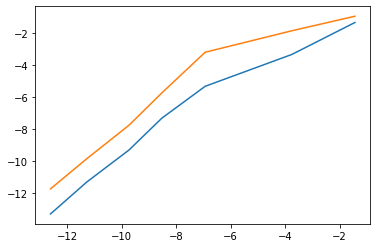

In [161]:
bias_squared=np.sum((mean_ml-tv_approx)**2,axis=1)
plt.plot(np.log2(np.sum((mean_ml-tv_approx)**2,axis=1)),np.log2((c2/2**np.array(range(7)))**2))
plt.plot(np.log2(np.sum((mean_ml-tv_approx)**2,axis=1)),np.log2(MSE-np.sum((mean_ml-tv_approx)**2,axis=1)))
print(coef(np.log2(np.sum((mean_ml-tv_approx)**2,axis=1)),np.log2((c2/2**np.array(range(7)))**2)))
print(bias_squared/(MSE-bias_squared),np.mean((bias_squared/(MSE-bias_squared))[1:]))

In [42]:
#MSE=np.sum(MSE,axis=1)

In [164]:
MSE

array([8.94486038e-01, 3.54717817e-01, 1.18287233e-01, 2.14869872e-02,
       5.77839112e-03, 1.48224773e-03, 4.52070244e-04])

Text(0, 0.5, 'log(Cost)')

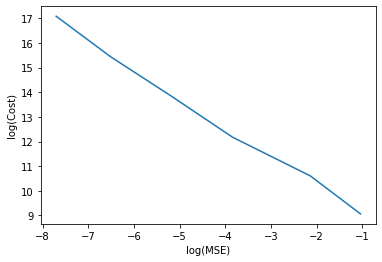

In [185]:
plt.plot(np.log(MSE)[1:],np.log(cost)[1:])
plt.xlabel("log(MSE)")
plt.ylabel("log(Cost)")

T=80, dim=2 up

## Parameter tunning F2

array([[ 3.14495008],
       [ 1.59437168],
       [-0.51489121],
       [ 1.90383178],
       [ 1.43133622],
       [ 2.12672621],
       [ 3.63808199],
       [ 5.67704909],
       [ 9.86045015],
       [10.84539502]])

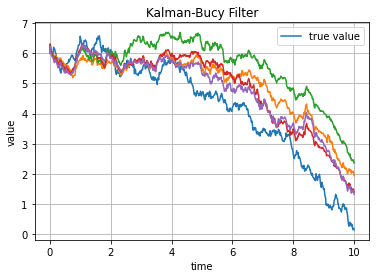

In [21]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity

T=10
lz=11
l=6
N=100
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=4
np.random.seed(seed_val_col)
collection_input=gen_model(dim)
## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    np.random.seed(seed_val_obs)
    [z,v] = gen_data(T,lz,collection_input)
    #[m,c] = KBF(T,l,lmax,z,collection_input)
    ems=np.zeros((B,J+1,dim,1))
    for i in range(B):
        ems[i] = DEnKBF(T,l,lz,z,N,collection_input)[0]
        
        #[m2,c2] = DEnKBF(T,l,lmax,z,N,collection_input)
v1=cut(T,lz,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
#print(m1[:,2].T[0])
#plt.plot(x1,m[:,0],label="KBF posterior mean estimate")
plt.plot(x1,v1[:,4],label="true value")
for i in range(B):
    plt.plot(x1,ems[i,:,4,0])
#plt.plot(x1,m2[:,0],label="DEnKBF posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
EnKBF(T,l,lz,z,N,collection_input)[0][-1]

In [22]:
dim

10

In [33]:
def Dfit_c1(seed_val,dim):
    np.random.seed(seed_val_col)
    l=5
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,Lmax,collection_input)[0]
    num_seq = np.zeros(6)
    for i in range(6):
        num_seq[i] = 50*2**i
    np.random.seed(seed_val)
    Rep=200
    evar=np.zeros(6)
    for numi in range(6):
        est=np.zeros(Rep)
        #print("numi=",numi)
        for rep in range(Rep):
            with np.errstate(divide='ignore'):
                mean_mat =DEnKBF(T,l,Lmax,z,int(num_seq[numi]),collection_input)[0]
                est[rep] = np.mean(mean_mat[-1,:])
                #print(est[rep])
        evar[numi] = np.var(est)
    
    x = np.log10(num_seq)
    #x=np.array([i for i in range(6)])
    y = np.log10(evar)
    b = coef(x,y)
    plt.plot(x,y)
    plt.plot(x,b[0]+b[1]*x)
    
    return 10**(b)

In [34]:
Lmax=11 
seed_val_col=5
seed_val_obs=5
dim=10
T=10
amm=4.
bmm=5.
cmm=30.

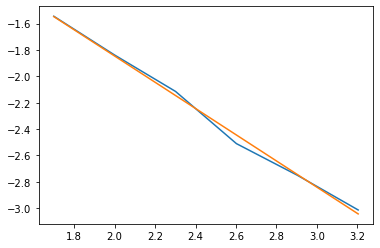

In [38]:
c1=Dfit_c1(6,dim)

compare with c1=1.5, seed_val=6

In [37]:
#2
c1

array([1.50352216, 0.10104041])

In [27]:
def Dfit_c3(seed_val,dim):
    np.random.seed(seed_val_col)
    #dim = 10
    #lmax=9
    N = 100
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,Lmax,collection_input)[0]
    delta_seq = np.zeros(l-l0+1)
    for ll in range(l0,l+1):
        delta_seq[ll-l0] = 2**(-ll)
    Rep=100
    evar=np.zeros(l-l0+1)
    np.random.seed(seed_val)
    for ll in range(l0,l+1):
        print("Current level ",ll,". ",l-ll,"remaining." )
        est = np.zeros(Rep)
        with progressbar.ProgressBar(max_value=Rep) as bar:
            for rep in range(Rep):
                with np.errstate(divide='ignore'):
                    [m,m1]=DCEnKBF(T,ll,Lmax,z,N,collection_input)
                    est[rep] = np.mean(m[-1,:]) - np.mean(m1[-1,:])
                    bar.update(rep)
        evar[ll-l0] = np.var(est)
        
    #x = np.log10(delta_seq[4:8])
    x=np.array(range(l0,l+1))
    y = np.log10(evar)
    b=coef(x,y)
    plt.plot(x,y)
    return N*10**(b)

Current level  5 .  4 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:24 Time:  0:00:24


Current level  6 .  3 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:45 Time:  0:00:45


Current level  7 .  2 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:01:46 Time:  0:01:46


Current level  8 .  1 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:03:31 Time:  0:03:31


Current level  9 .  0 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:05:05 Time:  0:05:05


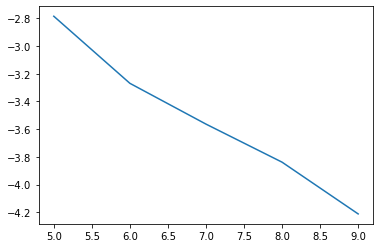

In [30]:
l0=5
l=9
c3=Dfit_c3(5,dim)

In [36]:
#1
c3

array([ 7.25845495, 45.49280948])

compare this with the 8. obtained for seed_val=4

In [193]:
c1=1.5
c2=0.5862156896272442
c3=8

In [196]:
C=4
Numcal(C,6,0)

array([23840.,  6112.,  3056.,  1528.,   764.,   384.,   192.])

In [197]:
def Numcal(C,L,l0):
    Num=np.zeros(L-l0+1)
    epsilon = np.sqrt(2)*c2 * 2**(-L)
    Num[0] = np.ceil(2*c1 * epsilon**(-2))
    for li in range(1,L-l0+1):
        Num[li]=np.maximum(np.ceil(2*epsilon**(-2)*c3*(L-l0)*2**(-li)),2)
        
    return(np.ceil(Num*C))

In [198]:
def DMLEnKBF(C,T,L,lmax,l0,z,collection_input):
    Num=Numcal(C,L,l0)
    telescopic_summand=np.zeros((L-l0+1,dim))
    [m,c]=DEnKBF(T,l0,lmax,z,int(Num[0]),collection_input)
    telescopic_summand[0]=m[-1,:,0]
    for l in range(l0+1,L+1):
        [m1,m2]=DCEnKBF(T,l,lmax,z,int(Num[l-l0]),collection_input)
        telescopic_summand[l-l0]=m1[-1,:,0]-m2[-1,:,0]
    est=np.sum(telescopic_summand,axis=0)
    return(est)

In [200]:
def Dsimulate_mse(seed_val):
    lmax = Lmax
    #dim = 5
    #T=10
    np.random.seed(seed_val_col)
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,lmax,collection_input)[0]
    N=500
    Rep=100
    
    tv_rep = np.zeros((Rep,dim))
    with progressbar.ProgressBar(max_value=Rep) as bar:
        for rep in range(Rep):
            tv_rep[rep] = DEnKBF(T,lmax,lmax,z,N,collection_input)[0][-1,:,0]
            bar.update(rep)
            
            
    tv_approx = np.mean(tv_rep,axis=0)
    mse_ml=np.zeros((L-l0+1,dim))
    levels=np.array(range(l0,L+1))
    mean_ml=np.zeros((L-l0+1,dim))
    delt_level=np.zeros(10)
    C=5.
    Rep=100
    costs=np.zeros(L-l0+1)
    for l in range(l0,L+1):
        est_ml=np.zeros((Rep,dim))
        #est_en=np.zeros(Rep)
        print("Current level is",l,".",L-l, "remaining.")
        with progressbar.ProgressBar(max_value=Rep) as bar:
            ML_real=np.zeros((Rep,dim))
            for rep in range(Rep):
                with np.errstate(divide='ignore'):
                    #mean_en = DEnKBF(T,l,lmax,z,N,collection_input)[0][-1,:]
                    #print(T,l)
                    ML_real[rep] = DMLEnKBF(C,T,l,lmax,l0,z,collection_input)
                    seed_j=0
                    while  math.isnan(ML_real[rep,0]):
                        np.random.seed(seed_j)
                        ML_real[rep] =DMLEnKBF(C,T,l,lmax,l0,z,collection_input)
                        #print(ML_real[rep])
                        seed_j+=1
                    est_ml[rep] = (ML_real[rep] - tv_approx)**2
                    #est_en[rep] = np.sum((mean_en - tv_approx)**2)
                    bar.update(rep)
            mean_ml[l-l0]=np.mean(ML_real,axis=0)       
            mse_ml[l-l0]=np.mean(est_ml,axis=0)
            costs[l-l0]=cost_mlenkbf(C,T,l,l0)
            
        #print(mse_ml[l-l0])
    
    return [mse_ml,levels,costs,mean_ml,tv_approx]

In [203]:
C=5
l0=0
N=100
lmax=6
np.random.seed(seed_val_col)
collection_input = gen_model(dim)
np.random.seed(seed_val_obs)
z = gen_data(T,Lmax,collection_input)[0]
#print(DMLEnKBF(C,T,6,Lmax,l0,z,collection_input))
#print(DEnKBF(T,lmax,Lmax,z,N,collection_input)[0][-1])

In [204]:
L=5
[MSE,levels,cost,mean_ml,tv_approx]=Dsimulate_mse(seed_val)

100% (100 of 100) |######################| Elapsed Time: 2:55:22 Time:  2:55:22
  4% (4 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:03

Current level is 0 . 5 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 1 . 4 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:08 Time:  0:00:08


Current level is 2 . 3 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:19 Time:  0:00:19


Current level is 3 . 2 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


Current level is 4 . 1 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:02:32 Time:  0:02:32


Current level is 5 . 0 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:21:21 Time:  0:21:21


once the simulation is finished copypaste the results and go to Dunkbf and run the CS and the ST

T=80, dim=2 down

In [205]:
tv_approx

array([-2.42638868,  0.85448171])

Great, the bias is well computed

In [222]:
#MSE=np.sum(MSE,axis=1)
MSE=np.array([0.57201138, 0.1460237 , 0.05408799, 0.01369782, 0.00319383,
       0.00077373])
cost=np.array([8.0000e+02, 9.6000e+03, 4.3200e+04, 2.0800e+05, 1.0576e+06,
       5.4536e+06])

In [209]:
[MSE,cost,mean_ml,tv_approx]=

[0.66699793 1.058958  ]
[0.69877933 0.26492017 0.07429193 0.14484015 0.25580178 0.37455687
 0.5517903 ] 0.2777001989513704


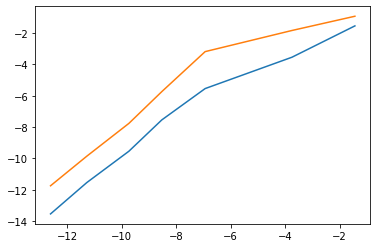

In [210]:
bias_squared=np.sum((mean_ml-tv_approx)**2,axis=1)
plt.plot(np.log2(np.sum((mean_ml-tv_approx)**2,axis=1)),np.log2((c2/2**np.array(range(7)))**2))
plt.plot(np.log2(np.sum((mean_ml-tv_approx)**2,axis=1)),np.log2(MSE-np.sum((mean_ml-tv_approx)**2,axis=1)))
print(coef(np.log2(np.sum((mean_ml-tv_approx)**2,axis=1)),np.log2((c2/2**np.array(range(7)))**2)))
print(bias_squared/(MSE-bias_squared),np.mean((bias_squared/(MSE-bias_squared))[1:]))

In [42]:
#MSE=np.sum(MSE,axis=1)

In [211]:
MSE

array([8.94486038e-01, 3.54717817e-01, 1.18287233e-01, 2.14869872e-02,
       5.77839112e-03, 1.48224773e-03, 4.52070244e-04])

Text(0, 0.5, 'log(Cost)')

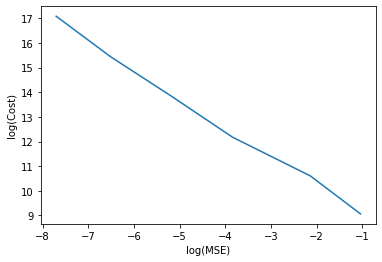

In [163]:
plt.plot(np.log(MSE)[1:],np.log(cost)[1:])
plt.xlabel("log(MSE)")
plt.ylabel("log(Cost)")

In [45]:
2**coef(np.log(MSE[1:]),np.log(c2*1/2**(np.array(range(1,6)))))T=80, dim=2 down

array([0.72016777, 1.43998275])

ValueError: x and y must have same first dimension, but have shapes (5,) and (6,)

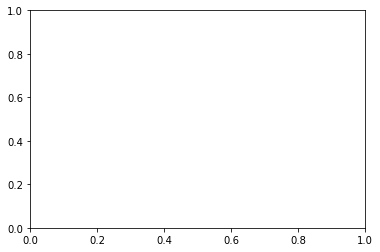

In [46]:
plt.plot(np.log(MSE[1:]),np.log(c2*(1/2)**(np.array(range(1,7)))))

version 1

ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

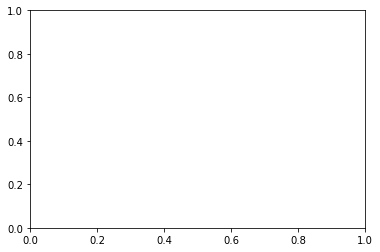

In [486]:
bias_squared=np.sum((mean_ml-tv_approx)**2,axis=1)

bias_squared=np.sum((mean_ml-tv_approx)**2,axis=1)
plt.plot(np.log2(np.sum((mean_ml-tv_approx)**2,axis=1)),np.log2((c2/2**np.array(range(7)))**2))
plt.plot(np.log2(MSE),np.log2((c2/2**np.array(range(7)))**2))
coef(np.log2(np.sum((mean_ml-tv_approx)**2,axis=1)),np.log2((c2/2**np.array(range(7)))**2))
print(bias_squared/(MSE-bias_squared),np.mean((bias_squared/(MSE-bias_squared))[1:]))

In [346]:
MSE=np.sum(MSE,axis=1)

In [388]:
MSE

array([2.46279211e+00, 2.01880794e+00, 2.78695136e-01, 4.96901893e-02,
       1.16941430e-02, 3.77292582e-03, 9.83988669e-04])

Text(0, 0.5, 'log(Cost)')

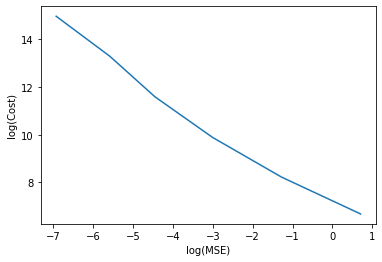

In [348]:
plt.plot(np.log(MSE)[1:],np.log(cost)[1:])
plt.xlabel("log(MSE)")
plt.ylabel("log(Cost)")

In [484]:
2**coef(np.log(MSE),np.log(c2*1/2**(np.array(range(0,6)))))

array([0.74197055, 1.44841991])

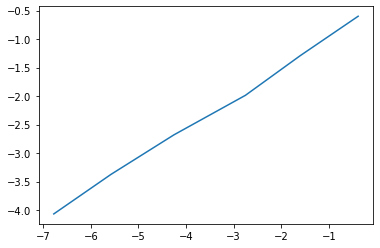

In [485]:
plt.plot(np.log(MSE),np.log(c2*(1/2)**(np.array(range(6)))))

In [319]:
MSE

array([2.67154566e+00, 2.74328240e+00, 2.77022324e-01, 4.97550851e-02,
       1.21880542e-02, 3.19852732e-03, 7.31169605e-04])

Text(0, 0.5, 'log(Cost)')

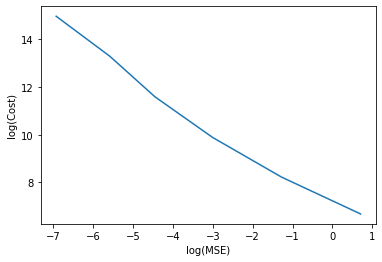

In [354]:
plt.plot(np.log(MSE)[1:],np.log(cost)[1:])
plt.xlabel("log(MSE)")
plt.ylabel("log(Cost)")


In [320]:
coef(np.log(MSE[1:]),np.log(c2*1/2**(np.array(range(1,7)))))

array([-1.3774844 ,  0.42910392])

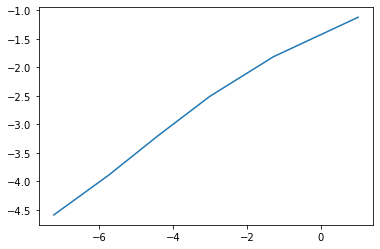

In [321]:
plt.plot(np.log(MSE[1:]),np.log(c2*1/2**(np.array(range(1,7)))))

In [267]:
cost

array([2.4500000e+02, 1.6625000e+03, 8.2250000e+03, 4.3137500e+04,
       2.4052000e+05, 1.3140925e+06, 7.0363650e+06])

In [247]:
MSE

array([1.23306697e+00, 8.53203441e-01, 1.39592273e-01, 2.95697552e-02,
       6.13551419e-03, 1.26673315e-03, 3.43098119e-04])

Text(0, 0.5, 'log(Cost)')

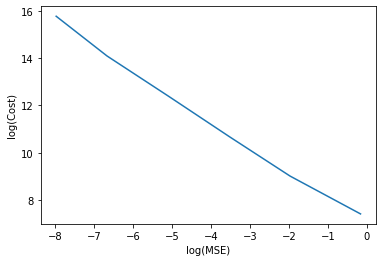

In [248]:
plt.plot(np.log(MSE)[1:],np.log(cost)[1:])
plt.xlabel("log(MSE)")
plt.ylabel("log(Cost)")


In [256]:
coef(np.log(MSE[1:]),np.log(c2*1/2**(np.array(range(1,7)))))

array([-0.98333938,  0.44208788])

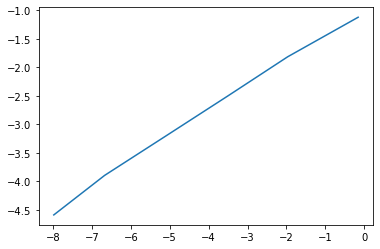

In [253]:
plt.plot(np.log(MSE[1:]),np.log(c2*1/2**(np.array(range(1,7)))))

## T=10, d=10

### Parameter tuning F1

array([[-9.91388651],
       [ 2.8159785 ],
       [ 9.65210242],
       [ 6.94528871],
       [-2.74270938],
       [ 4.28065243],
       [-6.68921517],
       [-5.22407267],
       [-6.3985988 ],
       [ 6.17746058]])

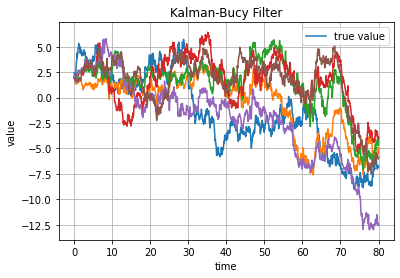

In [139]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity


amm=2.
bmm=2.
cmm=50.
b=2
T=80
lz=11
l=4
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=5
np.random.seed(seed_val_col)
collection_input=gen_model(dim)
## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    np.random.seed(seed_val_obs)
    [z,v] = gen_data(T,lz,collection_input)
    #[m,c] = KBF(T,l,lmax,z,collection_input)
    ems=np.zeros((B,J+1,dim,1))
    for i in range(B):
        ems[i] = EnKBF(T,l,lz,z,N,collection_input)[0]
        
        #[m2,c2] = DEnKBF(T,l,lmax,z,N,collection_input)
v1=cut(T,lz,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
#print(m1[:,2].T[0])
#plt.plot(x1,m[:,0],label="KBF posterior mean estimate")
plt.plot(x1,v1[:,0],label="true value")
for i in range(B):
    plt.plot(x1,ems[i,:,0,0])
#plt.plot(x1,m2[:,0],label="DEnKBF posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
EnKBF(T,l,lz,z,N,collection_input)[0][-1]

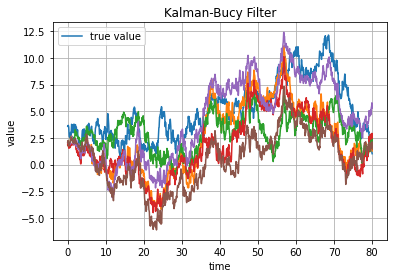

In [119]:
index=5
plt.plot(x1,v1[:,index],label="true value")
for i in range(B):
    plt.plot(x1,ems[i,:,index,0])
#plt.plot(x1,m2[:,0],label="DEnKBF posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()

In [120]:
def fit_c1(seed_val,dim):
    np.random.seed(seed_val_col)
    l=4
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,Lmax,collection_input)[0]
    num_seq = np.zeros(6)
    for i in range(6):
        num_seq[i] = 50*2**i
    np.random.seed(seed_val)
    Rep=100
    evar=np.zeros(6)
    for numi in range(6):
        est=np.zeros(Rep)
        #print("numi=",numi)
        for rep in range(Rep):
            with np.errstate(divide='ignore'):
                mean_mat =EnKBF(T,l,Lmax,z,int(num_seq[numi]),collection_input)[0]
                est[rep] = np.mean(mean_mat[-1,:])
                #print(est[rep])
        evar[numi] = np.var(est)
    
    x = np.log10(num_seq)
    #x=np.array([i for i in range(6)])
    y = np.log10(evar)
    b = coef(x,y)
    plt.plot(x,y)
    plt.plot(x,b[0]+b[1]*x)
    
    return 10**(b)

In [135]:
T=10
dim=10
Lmax=11
seed_val_col=5
seed_val_obs=5

amm=2.
bmm=2.
cmm=50.
b=2

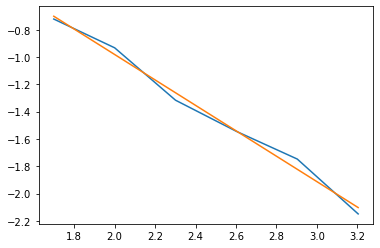

In [122]:
c1=fit_c1(42,dim)

In [123]:
#2
c1

array([7.61269071, 0.11710295])

In [140]:
def fit_c3(seed_val,dim):
    np.random.seed(seed_val_col)
    #dim = 10
    #lmax=9
    N = 50
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,Lmax,collection_input)[0]
    delta_seq = np.zeros(lmaxc3-l0+1)
    for l in range(l0,lmaxc3+1):
        delta_seq[l-l0] = 2**(-l)
    Rep=100
    evar=np.zeros(lmaxc3-l0+1)
    np.random.seed(seed_val)
    for l in range(l0,lmaxc3+1):
        print("Current level ",l,". ",lmaxc3-l,"remaining." )
        est = np.zeros(Rep)
        with progressbar.ProgressBar(max_value=Rep) as bar:
            for rep in range(Rep):
                with np.errstate(divide='ignore'):
                    [m,m1]=CEnKBF(T,l,Lmax,z,N,collection_input)
                    est[rep] = np.mean(m[-1,:]) - np.mean(m1[-1,:])
                    bar.update(rep)
        evar[l-l0] = np.var(est)
        
    #x = np.log10(delta_seq[4:8])
    x=np.array(range(l0,lmaxc3+1))
    y = np.log10(evar)
    b=coef(x,y)
    plt.plot(x,y)
    return N*10**(b)

Current level  5 .  3 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:01:25 Time:  0:01:25


Current level  6 .  2 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:03:04 Time:  0:03:04


Current level  7 .  1 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:06:00 Time:  0:06:00


Current level  8 .  0 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:11:02 Time:  0:11:02


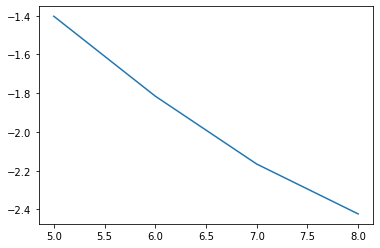

In [142]:
l0=5
lmaxc3=8
c3=fit_c3(2,dim)

In [144]:
#1
c3

array([ 0.07894818, 48.55283227])

In [145]:
c1=0.90098574
c2=0.633350592759386
c3=0.07894818

In [148]:
C=3
Numcal(C,6,0)

array([27603.,  7257.,  3630.,  1815.,   909.,   456.,   228.])

In [70]:
def simulate_mse(seed_val):
    
    lmax = Lmax
    #dim = 5
    #T=10
    np.random.seed(seed_val_col)
    collection_input = gen_model(dim)
    np.random.seed(seed_val_obs)
    z = gen_data(T,lmax,collection_input)[0]
    N=500
    Rep=100
    
    tv_rep = np.zeros((Rep,dim))
    with progressbar.ProgressBar(max_value=Rep) as bar:
        for rep in range(Rep):
            tv_rep[rep] = EnKBF(T,lmax,lmax,z,N,collection_input)[0][-1,:,0]
            bar.update(rep)
            
            
    tv_approx = np.mean(tv_rep,axis=0)
    mse_ml=np.zeros((L-l0+1,dim))
    levels=np.array(range(l0,L+1))
    mean_ml=np.zeros((L-l0+1,dim))
    delt_level=np.zeros(10)
    C=3.
    Rep=100
    costs=np.zeros(L-l0+1)
    for l in range(l0,L+1):
        est_ml=np.zeros((Rep,dim))
        #est_en=np.zeros(Rep)
        print("Current level is",l,".",L-l, "remaining.")
        with progressbar.ProgressBar(max_value=Rep) as bar:
            ML_real=np.zeros((Rep,dim))
            for rep in range(Rep):
                with np.errstate(divide='ignore'):
                    #mean_en = DEnKBF(T,l,lmax,z,N,collection_input)[0][-1,:]
                    #print(T,l)
                    ML_real[rep] = MLEnKBF(C,T,l,lmax,l0,z,collection_input)
                    seed_j=0
                    while  math.isnan(ML_real[rep,0]):
                        np.random.seed(seed_j)
                        ML_real[rep] =MLEnKBF(C,T,l,lmax,l0,z,collection_input)
                        #print(ML_real[rep])
                        seed_j+=1
                    est_ml[rep] = (ML_real[rep] - tv_approx)**2
                    #est_en[rep] = np.sum((mean_en - tv_approx)**2)
                    bar.update(rep)
            mean_ml[l-l0]=np.mean(ML_real,axis=0)       
            mse_ml[l-l0]=np.mean(est_ml,axis=0)
            costs[l-l0]=cost_mlenkbf(C,T,l,l0)
            
        #print(mse_ml[l-l0])
    
    return [mse_ml,levels,costs,mean_ml,tv_approx]

In [71]:
def Numcal(C,L,l0):
    Num=np.zeros(L-l0+1)
    epsilon = np.sqrt(2)*c2 * 2**(-L)
    Num[0] = np.ceil(2*c1 * epsilon**(-2))
    for li in range(1,L-l0+1):
        Num[li]=np.maximum(np.ceil(2*epsilon**(-2)*c3*(L-l0)*2**(-li)),2)
        
    return(np.ceil(Num*C))

In [72]:
def MLEnKBF(C,T,L,lmax,l0,z,collection_input):
    Num=Numcal(C,L,l0)
    telescopic_summand=np.zeros((L-l0+1,dim))
    [m,c]=EnKBF(T,l0,lmax,z,int(Num[0]),collection_input)
    telescopic_summand[0]=m[-1,:,0]
    for l in range(l0+1,L+1):
        [m1,m2]=CEnKBF(T,l,lmax,z,int(Num[l-l0]),collection_input)
        telescopic_summand[l-l0]=m1[-1,:,0]-m2[-1,:,0]
    est=np.sum(telescopic_summand,axis=0)
    return(est)

In [149]:
C=3
l0=0
N=100
lmax=6
np.random.seed(seed_val_col)
collection_input = gen_model(dim)
np.random.seed(seed_val_obs)
z = gen_data(T,Lmax,collection_input)[0]
print(MLEnKBF(C,T,6,Lmax,l0,z,collection_input))
#print(EnKBF(T,lmax,Lmax,z,N,collection_input)[0][-1])

[-2.43830611  0.86486738]


In [150]:
L=6
[MSE,levels,cost,mean_ml,tv_approx]=simulate_mse(seed_val)

100% (100 of 100) |######################| Elapsed Time: 2:17:47 Time:  2:17:47
  6% (6 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:02

Current level is 0 . 6 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 1 . 5 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 2 . 4 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:14 Time:  0:00:14


Current level is 3 . 3 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:35 Time:  0:00:35


Current level is 4 . 2 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Current level is 5 . 1 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:16:03 Time:  0:16:03


Current level is 6 . 0 remaining.


100% (100 of 100) |######################| Elapsed Time: 4:19:13 Time:  4:19:13
